# Streak simultaneous measurement 

Laser on the streak, splitted to the photodiode

In [7]:
%run ../../PhD-utils/AWAKE-toolbox.py

import matplotlib.pyplot as plt
%matplotlib inline

import glob

Version 0.1
Please report bugs to eugenio.senes@cern.ch
Use at your own risk.


In [13]:
scopePath = './Photodiode-on-LeCroy18GHz'
imPath = './LaserOnStreak+photodiode/Gain40_slit20um_1ns_lecroy'

In [48]:
# Init the dataframe
data = pnd.DataFrame([],columns=['scope_t','scope_V','scope_t_sampling'])

# Scope traces

## Load

In [49]:
scopePathList = sorted(glob.glob(scopePath+'/*.txt'))


In [50]:
name = '0'
for k, label in enumerate(scopePathList):
    name = str(k)
    data.loc[name] = load_data_LeCroy(scopePathList[k])

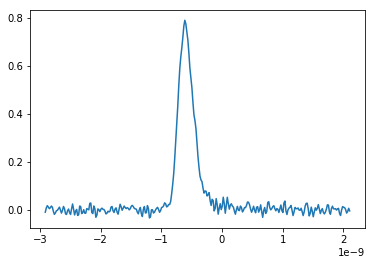

In [51]:
ll = 3
plt.plot(data["scope_t"].iloc[ll], data["scope_V"].iloc[ll],'-')

## FFT

In [54]:
# add columns to dataframe
data['scope_f'] = [np.empty(0,dtype=float)]*len(data)
data['scope_dB'] = [np.empty(0,dtype=float)]*len(data)

In [56]:
# do the fft
for k in data.index:
    data["scope_f"].loc[k], data["scope_dB"].loc[k]  = doFFT(data["scope_t"].loc[k], data["scope_V"].loc[k])

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


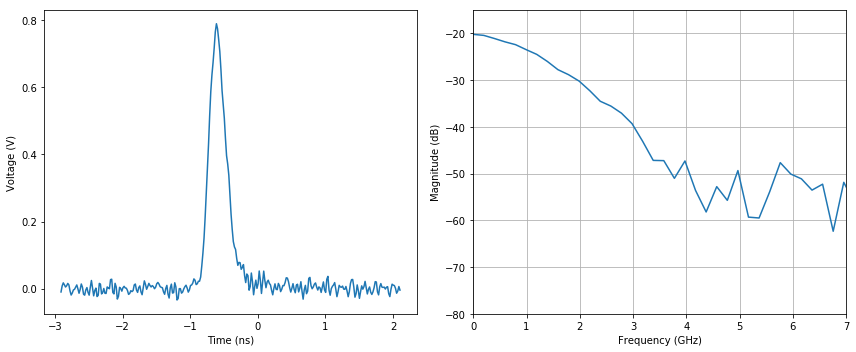

In [102]:
ll = 3

fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].plot(1e9*data["scope_t"].iloc[ll], data["scope_V"].iloc[ll],'-')
ax[0].set_xlabel('Time (ns)')
ax[0].set_ylabel('Voltage (V)')
# ax[0].set_xlim(-1, 0)
# ax[0].plot([-1,0],[np.max(data["scope_V"].iloc[ll])/2., np.max(data["scope_V"].iloc[ll])/2.],'-')
# ax[0].axvline(x=-0.74)
# ax[0].axvline(x=-0.46)


ax[1].plot(1e-9*data["scope_f"].iloc[ll], dB(data["scope_dB"].iloc[ll]),'-')
ax[1].set_xlabel('Frequency (GHz)')
ax[1].set_ylabel('Magnitude (dB)')
ax[1].set_xlim(0,7)
ax[1].set_ylim(-80,-15)
ax[1].grid()

plt.tight_layout()

In [97]:
data.head()

,scope_t,scope_V,scope_t_sampling,scope_f,scope_dB
0,"[-2.91346e-09, -2.89679e-09, -2.88012e-09, -2....","[-0.0119916, 0.0193935, 0.0302695, 0.0110034, ...",1.667000e-11,"[-29994001199.759853, -29795365430.225018, -29...","[4.5033018543051264e-05, 4.142502954936343e-05..."
1,"[-2.9041e-09, -2.88744e-09, -2.87077e-09, -2.8...","[-0.0103688, 0.0115213, 0.0133167, 0.0163896, ...",1.666000e-11,"[-30012004801.921097, -29813249803.23288, -296...","[0.0001827025841059608, 0.0001837439487857873,..."
2,"[-2.914e-09, -2.89733e-09, -2.88066e-09, -2.86...","[0.00316577, 0.0250214, 0.036657, 0.0236058, -...",1.667000e-11,"[-29994001199.759853, -29795365430.225018, -29...","[2.195483973510254e-05, 2.0869709198626396e-05..."
3,"[-2.91245e-09, -2.89579e-09, -2.87912e-09, -2....","[-0.0100236, 0.00789597, 0.0171147, 0.0113487,...",1.666000e-11,"[-30012004801.921097, -29813249803.23288, -296...","[3.655973509926221e-06, 5.067771387428612e-06,..."
4,"[-2.90679e-09, -2.89012e-09, -2.87346e-09, -2....","[0.00361462, -0.0215901, -0.0228676, 0.0061696...",1.667000e-11,"[-29994001199.759853, -29795365430.225018, -29...","[2.9957860927153218e-05, 2.7718974416884174e-0..."


In [99]:
1./1.667000e-11 *1e-9

59.9880023995201

# Load images

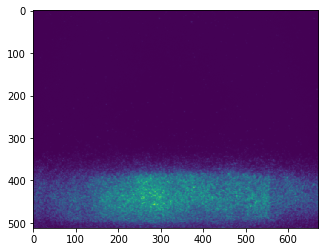

In [109]:
plt.imshow(np.genfromtxt("./prova.csv", delimiter=','))